In [1]:
import tangos
import pynbody

import numpy as np
import pandas as pd

import astropy.units as u
from astropy.io import fits
from astropy.utils import data
from astropy.wcs import WCS

import matplotlib.pyplot as plt

from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

import glob

import sys
sys.path.insert(0, '../util/')
from util import util

# Population Figure

# Profiles

In [2]:
haloIDs = [431, 468, 492, 502, 523, 569]

In [3]:
def getfilepath(h):
    '''
    gets file path for data of halo h in [CDM, SIDM] order 
    '''
    
    cdm = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r'+str(h)+'.romulus25.3072g1HsbBH/r'+str(h)
    cdm += '.romulus25.3072g1HsbBH.004096'
    
    sidm = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r'+str(h)+'.romulus25cvdXsec.3072g1HsbBH/r'+str(h)
    sidm +='.romulus25cvdXsec.3072g1HsbBH.004096'
    
    return [cdm,sidm]

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


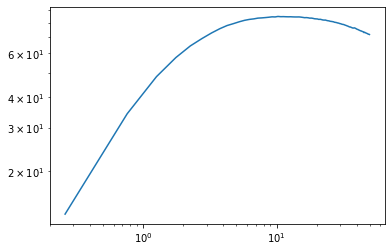

In [4]:
cdmFile = getfilepath(haloIDs[0])[0] + '/r'+str(haloIDs[0])+'.romulus25.3072g1HsbBH.004096'

sCDM = pynbody.load(cdmFile)
sCDM.physical_units()
hCDM = sCDM.halos()[1]

cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
sCDM['pos'] -= cen_pot

# profile range
pmin = 0.01
#pmax = pynbody.analysis.halo.virial_radius(h1) / 4
pmax = 4

p= pynbody.analysis.profile.Profile(hCDM.d, rmin='0.01 kpc', rmax='50 kpc', type='lin')
test = pynbody.analysis.profile.v_circ(p)
plt.plot(p['rbins'], test)

plt.xscale('log')
plt.yscale('log')

In [11]:
np.median(hCDM.g['v_disp'])

SimArray(56.72289333, 'km s**-1')

In [9]:
hCDM.derivable_keys()

['HII',
 'HeIII',
 'ne',
 'hetot',
 'hydrogen',
 'feh',
 'oxh',
 'ofe',
 'mgfe',
 'nefe',
 'sife',
 'c_s',
 'c_s_turb',
 'mjeans',
 'mjeans_turb',
 'ljeans',
 'ljeans_turb',
 'r',
 'rxy',
 'vr',
 'v2',
 'vt',
 'ke',
 'te',
 'j',
 'j2',
 'jz',
 'vrxy',
 'vcxy',
 'vphi',
 'vtheta',
 'v_mean',
 'v_disp',
 'v_curl',
 'vorticity',
 'v_div',
 'age',
 'u_mag',
 'u_lum_den',
 'b_mag',
 'b_lum_den',
 'v_mag',
 'v_lum_den',
 'r_mag',
 'r_lum_den',
 'i_mag',
 'i_lum_den',
 'j_mag',
 'j_lum_den',
 'h_mag',
 'h_lum_den',
 'k_mag',
 'k_lum_den',
 'U_mag',
 'U_lum_den',
 'B_mag',
 'B_lum_den',
 'V_mag',
 'V_lum_den',
 'R_mag',
 'R_lum_den',
 'I_mag',
 'I_lum_den',
 'J_mag',
 'J_lum_den',
 'H_mag',
 'H_lum_den',
 'K_mag',
 'K_lum_den',
 'theta',
 'alt',
 'az',
 'cs',
 'mu',
 'p',
 'u',
 'temp',
 'zeldovich_offset',
 'aform',
 'tform',
 'iord_argsort',
 'smooth',
 'rho']

In [8]:
def fourPanelProfiles(hID, d=1):
    # get data paths for specified halo 
    cdmPath, sidmPath = getfilepath(hID)
    
    cdmFile = cdmPath + '/r'+str(hID)+'.romulus25.3072g1HsbBH.004096'
    sidmFile = sidmPath + '/r'+str(hID)+'.romulus25cvdXsec.3072g1HsbBH.004096'
    
    orientation = 0
    
    fig, axs = plt.subplots(2,2, figsize=(12,12), facecolor='white')
    
    sCDM = pynbody.load(cdmFile)
    sSIDM = pynbody.load(sidmFile)
    
    sCDM.physical_units()
    sSIDM.physical_units()
    
    hCDM = sCDM.halos()[1]
    hSIDM = sSIDM.halos()[1]
    
    # center based on potential
    cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
    sCDM['pos'] -= cen_pot
    cen_pot = pynbody.analysis.halo.center(hSIDM, mode='pot', retcen=True)
    sSIDM['pos'] -= cen_pot
    
    # profile range
    pmin = '0.01 kpc'
    #pmax = pynbody.analysis.halo.virial_radius(h1) / 4
    pmax = '50 kpc'
    
    # rotation curve
    pdCDM = pynbody.analysis.profile.Profile(hCDM.d, rmin=pmin, rmax=pmax, type='lin')
    pgCDM = pynbody.analysis.profile.Profile(hCDM.g, rmin=pmin, rmax=pmax, type='lin')
    psCDM = pynbody.analysis.profile.Profile(hCDM.s, rmin=pmin, rmax=pmax, type='lin')
    pCDM  = pynbody.analysis.profile.Profile(hCDM,   rmin=pmin, rmax=pmax, type='lin')
    
    pdSIDM = pynbody.analysis.profile.Profile(hSIDM.d, rmin=pmin, rmax=pmax, type='lin')
    pgSIDM = pynbody.analysis.profile.Profile(hSIDM.g, rmin=pmin, rmax=pmax, type='lin')
    psSIDM = pynbody.analysis.profile.Profile(hSIDM.s, rmin=pmin, rmax=pmax, type='lin')
    pSIDM  = pynbody.analysis.profile.Profile(hSIDM,   rmin=pmin, rmax=pmax, type='lin')
    
    pdCDM2 = pynbody.analysis.profile.v_circ(pdCDM)
    pdSIDM2 = pynbody.analysis.profile.v_circ(pdSIDM)
    
    cdmC = 'coral'
    sidmC = 'royalblue'
    lw = 3
    
    key = 'density'
    if d == 0:
        key = 'v_circ'
    axs[0,0].plot(pdCDM['rbins'], pdCDM[key], c=cdmC, linewidth=lw)
    axs[0,0].plot(pdSIDM['rbins'], pdSIDM[key], c=sidmC, linewidth=lw)
   # if d==0:
        #axs[0,0].plot(pdCDM['rbins'], pdCDM2, c='red', linestyle='--', linewidth=2)
        #axs[0,0].plot(pdSIDM['rbins'], pdSIDM2, c='blue', linestyle='--', linewidth=2)
    
    axs[0,1].plot(pgCDM['rbins'], pgCDM[key], c=cdmC, linewidth=lw)
    axs[0,1].plot(pgSIDM['rbins'], pgSIDM[key], c=sidmC, linewidth=lw)
    
    axs[1,0].plot(psCDM['rbins'], psCDM[key], c=cdmC, linewidth=lw)
    axs[1,0].plot(psSIDM['rbins'], psSIDM[key], c=sidmC, linewidth=lw)
    
    axs[1,1].plot(pCDM['rbins'], pCDM[key], c=cdmC, linewidth=lw)
    axs[1,1].plot(pSIDM['rbins'], pSIDM[key], c=sidmC, linewidth=lw)
    
    axs[0,0].set_xscale('log')
    axs[0,0].set_yscale('log')
    axs[0,1].set_xscale('log')
    axs[0,1].set_yscale('log')
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,1].set_xscale('log')
    axs[1,1].set_yscale('log')
    
    plt.suptitle('Density Profiles for Galaxy '+str(hID), fontsize=20)
    if d == 0: plt.suptitle('Rotation Profiles for Galaxy '+str(hID), fontsize=20)
        
    axs[0,0].set_title('Dark Matter', fontsize=16)
    axs[0,1].set_title('Gas', fontsize=16)
    axs[1,0].set_title('Stars', fontsize=16)
    axs[1,1].set_title('All', fontsize=16)
    
    axs[0,0].legend(['CDM', 'SIDM'])
    
    plt.tight_layout()

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this 

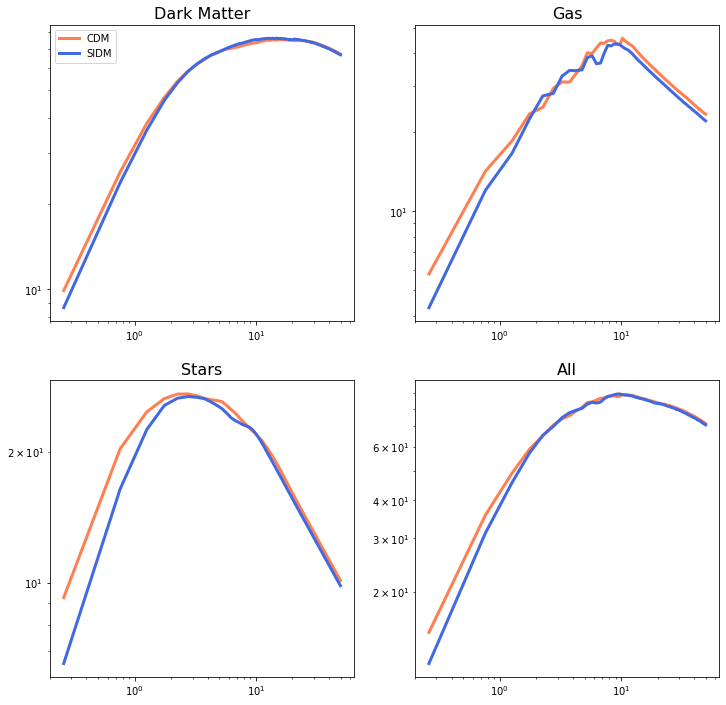

<Figure size 432x288 with 0 Axes>

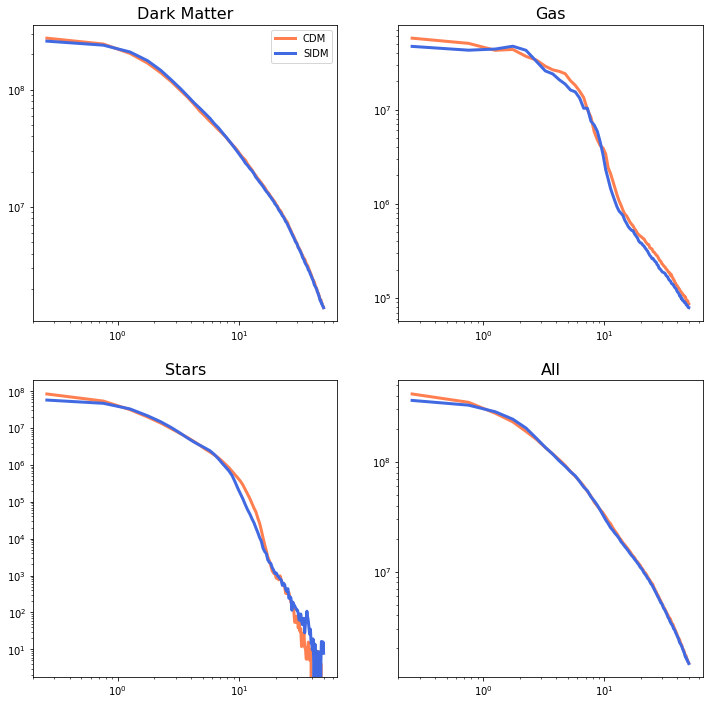

<Figure size 432x288 with 0 Axes>

In [9]:
hidx = 1

fourPanelProfiles(haloIDs[hidx], d=0)
plt.savefig('../figures/RotProfiles/r'+str(haloIDs[hidx])+'_rotation.png')

fourPanelProfiles(haloIDs[hidx], d=1)
plt.savefig('../figures/DenProfiles/r'+str(haloIDs[hidx])+'_density.png')

In [26]:
def eightPanelProfiles(hID, withSIDM=False):
    # get data paths for specified halo 
    cdmPath, sidmPath = getfilepath(hID)
    
    cdmFile = cdmPath + '/r'+str(hID)+'.romulus25.3072g1HsbBH.004096'
    
    fig, axs = plt.subplots(2,4, figsize=(16,8), facecolor='white')
    
    sCDM = pynbody.load(cdmFile)
    sCDM.physical_units()
    hCDM = sCDM.halos()[1]
    sCDM.physical_units()
    hCDM = sCDM.halos()[1]
    
    # center based on potential
    cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
    sCDM['pos'] -= cen_pot
    
    # profile range
    pmin = '0.01 kpc'
    #pmax = pynbody.analysis.halo.virial_radius(h1) / 4
    pmax = '50 kpc'
    
    # rotation curve
    pdCDM = pynbody.analysis.profile.Profile(hCDM.d, rmin=pmin, rmax=pmax, type='lin')
    pgCDM = pynbody.analysis.profile.Profile(hCDM.g, rmin=pmin, rmax=pmax, type='lin')
    psCDM = pynbody.analysis.profile.Profile(hCDM.s, rmin=pmin, rmax=pmax, type='lin')
    pCDM  = pynbody.analysis.profile.Profile(hCDM,   rmin=pmin, rmax=pmax, type='lin')
    
    pdCDM2 = pynbody.analysis.profile.v_circ(pdCDM)
    
    cdmC = 'firebrick'
    sidmC = 'royalblue'
    lw = 3
    
    axs[0,0].plot(pdCDM['rbins'], pdCDM['density'], c=cdmC, linewidth=lw)    
    axs[0,1].plot(pgCDM['rbins'], pgCDM['density'], c=cdmC, linewidth=lw)
    axs[1,0].plot(psCDM['rbins'], psCDM['density'], c=cdmC, linewidth=lw)
    axs[1,1].plot(pCDM['rbins'], pCDM['density'], c=cdmC, linewidth=lw)
    
    axs[0,0].set_xscale('log')
    axs[0,0].set_yscale('log')
    axs[0,1].set_xscale('log')
    axs[0,1].set_yscale('log')
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,1].set_xscale('log')
    axs[1,1].set_yscale('log')
    
    plt.suptitle('Profiles for Galaxy '+str(hID), fontsize=20)
        
    axs[0,0].set_title('Density of Dark Matter', fontsize=16)
    axs[0,1].set_title('Density of Gas', fontsize=16)
    axs[1,0].set_title('Density of Stars', fontsize=16)
    axs[1,1].set_title('Density of All', fontsize=16)
    
    axs[0,2].plot(pdCDM['rbins'], pdCDM['v_circ'], c=cdmC, linewidth=lw)
    axs[0,3].plot(pgCDM['rbins'], pgCDM['v_circ'], c=cdmC, linewidth=lw)
    axs[1,2].plot(psCDM['rbins'], psCDM['v_circ'], c=cdmC, linewidth=lw)
    axs[1,3].plot(pCDM['rbins'], pCDM['v_circ'], c=cdmC, linewidth=lw)
    
    # v_circ from defn 
    G = 6.67e-7
    #axs[1,3].plot(pCDM['rbins'], np.sqrt((G*pCDM['mass_enc'])/pCDM['rbins']) )
    
    axs[0,2].set_xscale('log')
    axs[0,2].set_yscale('log')
    axs[0,3].set_xscale('log')
    axs[0,3].set_yscale('log')
    axs[1,2].set_xscale('log')
    axs[1,2].set_yscale('log')
    axs[1,3].set_xscale('log')
    axs[1,3].set_yscale('log')
    
    axs[0,2].set_title('Rotation of Dark Matter', fontsize=16)
    axs[0,3].set_title('Rotation of Gas', fontsize=16)
    axs[1,2].set_title('Rotation of Stars', fontsize=16)
    axs[1,3].set_title('Rotation of All', fontsize=16)
    
    if withSIDM:
        sidmFile = sidmPath + '/r'+str(hID)+'.romulus25cvdXsec.3072g1HsbBH.004096'
        
        sSIDM = pynbody.load(sidmFile)
        sSIDM.physical_units()
        hSIDM = sSIDM.halos()[1]
        
        cen_pot = pynbody.analysis.halo.center(hSIDM, mode='pot', retcen=True)
        sSIDM['pos'] -= cen_pot
        
        pdSIDM = pynbody.analysis.profile.Profile(hSIDM.d, rmin=pmin, rmax=pmax, type='lin')
        pgSIDM = pynbody.analysis.profile.Profile(hSIDM.g, rmin=pmin, rmax=pmax, type='lin')
        psSIDM = pynbody.analysis.profile.Profile(hSIDM.s, rmin=pmin, rmax=pmax, type='lin')
        pSIDM  = pynbody.analysis.profile.Profile(hSIDM,   rmin=pmin, rmax=pmax, type='lin')
        
        axs[0,0].plot(pdSIDM['rbins'], pdSIDM['density'], c=sidmC, linewidth=lw)
        axs[0,1].plot(pgSIDM['rbins'], pgSIDM['density'], c=sidmC, linewidth=lw)
        axs[1,0].plot(psSIDM['rbins'], psSIDM['density'], c=sidmC, linewidth=lw)
        axs[1,1].plot(pSIDM['rbins'], pSIDM['density'], c=sidmC, linewidth=lw)
        
        pdSIDM2 = pynbody.analysis.profile.v_circ(pdSIDM)
        
        axs[0,2].plot(pdSIDM['rbins'], pdSIDM['v_circ'], c=sidmC, linewidth=lw)
        axs[0,3].plot(pgSIDM['rbins'], pgSIDM['v_circ'], c=sidmC, linewidth=lw)
        axs[1,2].plot(psSIDM['rbins'], psSIDM['v_circ'], c=sidmC, linewidth=lw)
        axs[1,3].plot(pSIDM['rbins'], pSIDM['v_circ'], c=sidmC, linewidth=lw)
    
        axs[0,0].legend(['CDM', 'SIDM'])
    
    fig.tight_layout()
    
    #if withSIDM:
        #plt.savefig('../figures/DenRotProfiles/r'+str(haloIDs[i])+'_8panel_2.png')
    #else:
        #plt.savefig('../figures/DenRotProfiles/r'+str(haloIDs[i])+'_8panel.png')

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


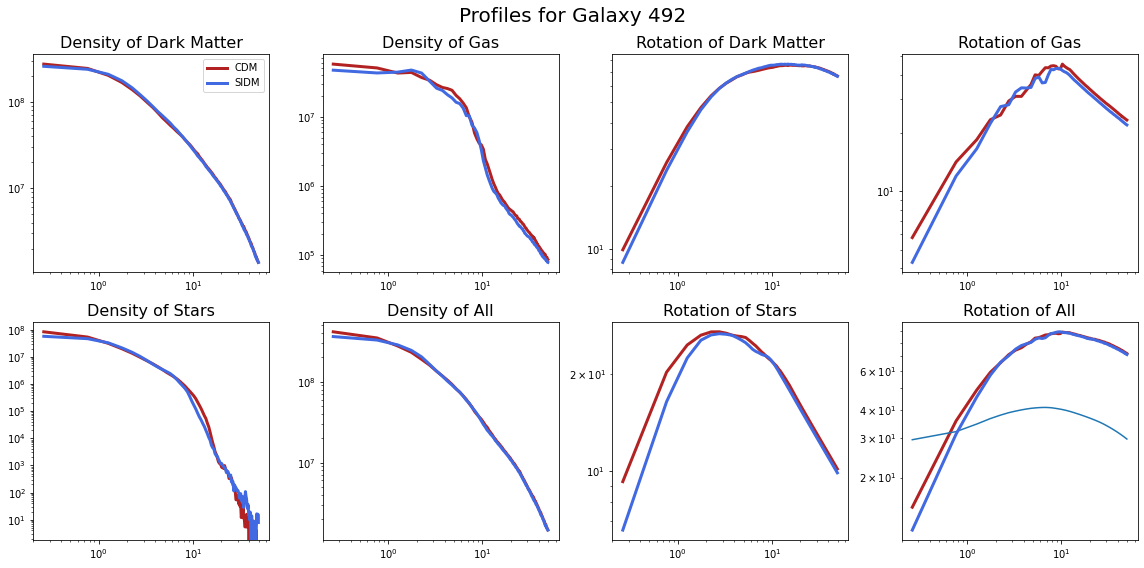

In [27]:
eightPanelProfiles(haloIDs[2], withSIDM=True)

# H1

In [4]:
fpath = getfilepath(431)

In [5]:
h1files = glob.glob(fpath[1]+'/*.fits')
h1files.sort()

In [6]:
# 36 x 54 x 54
data = fits.open(h1files[0])[0].data

In [7]:
h1files

['/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25cvdXsec.3072g1HsbBH/r431.romulus25cvdXsec.3072g1HsbBH.004096/r431.alfalfa_hi.x.fits',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25cvdXsec.3072g1HsbBH/r431.romulus25cvdXsec.3072g1HsbBH.004096/r431.alfalfa_hi.y.fits',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25cvdXsec.3072g1HsbBH/r431.romulus25cvdXsec.3072g1HsbBH.004096/r431.alfalfa_hi.z.fits']

In [8]:
fits.open(h1files[0])[0].header

SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    3 /                                                
NAXIS1  =                   54 /                                                
NAXIS2  =                   54 /                                                
NAXIS3  =                   36 /                                                
CTYPE1  = 'KPC-LIN'            /                                                
CUNIT1  = 'KPC'                /                                                
CRVAL1  =          -100.000005 /                                                
CDELT1  =             3.703704 /                                                
CRPIX1  =                  1.0 /                                                
CTYPE2  = 'KPC-LIN'            /                                                
CUNIT2  = 'KPC'             

In [9]:
# function to perform integration 
def integrateSpectral(data, initSpd, deltaSpd):
    start = 0
    end = len(data)

    tot = []
    for i in range(start,end):
        d = np.nan_to_num(np.array(data[i,:,:]), True, nan=0.0)
        d = d.flatten()
        tot.append(sum(d))

    vmax = max(tot)

    # make x-axis for line width figure 
    x = []
    for i in range(len(data)):
        x.append(initSpd+i*deltaSpd)
        
    return x, tot

In [10]:
# integrating over spectral axis
start = 0
end = len(data)

tot = []
for i in range(start,end):
    d = np.nan_to_num(np.array(data[i,:,:]), True, nan=0.0)
    d = d.flatten()
    tot.append(sum(d))
    
vmax = max(tot)

# make x-axis for line width figure 
st = -194.4
d = 11.2
x = []
for i in range(len(data)):
    x.append(st+i*d)

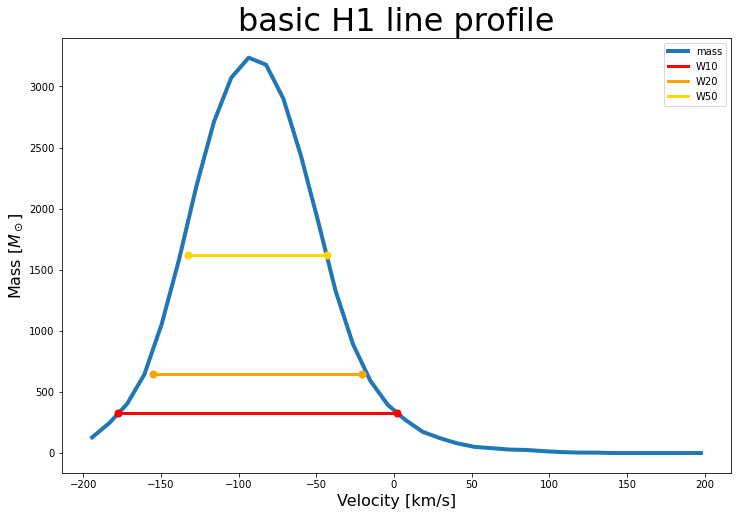

In [11]:
plt.figure(figsize=(12,8))

plt.plot(x,tot, linewidth=4)

plt.xlabel('Velocity [km/s]', fontsize=16)
plt.ylabel('Mass [$M_\odot$]', fontsize=16)
plt.title('basic H1 line profile', fontsize=32)

intervals = [10, 20, 50]
c = ['red', 'orange', 'gold']
for i,p in enumerate(intervals):
    val = (p/100)*vmax
    
    idxs_mass = np.argwhere(np.diff(np.sign(tot - np.full(len(tot),val)))).flatten()
    x1 = (x[idxs_mass[0]]+x[idxs_mass[0]+1])/2
    x2 = (x[idxs_mass[1]]+x[idxs_mass[1]+1])/2
    
    plt.plot([x1,x2],[val,val], linewidth=3, c=c[i], zorder=2)
    plt.scatter([x1,x2],[val,val], c=c[i], s=50, label='_nolegend_', zorder=2)
    
plt.legend(['mass', 'W10', 'W20', 'W50'])

1.4154592

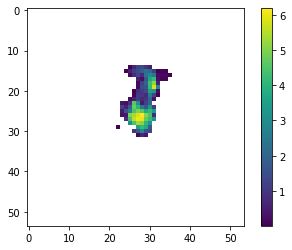

In [12]:
plt.imshow(data[18,:,:])
plt.colorbar()
data[18,30,30]

In [13]:
data.flatten()[18*30*30]

nan

In [112]:
f = fits.open('/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r492.romulus25.3072g1HsbBH/r492.romulus25.3072g1HsbBH.004096/r492.alfalfa_hi.x.fits')

In [163]:
bscale = f[0].header['BSCALE']
bzero = f[0].header['BZERO']
blank = f[0].header['BLANK']

d2 = np.nan_to_num(data, nan=blank) * bscale + bzero
d3 = np.power(np.full(d2.shape,10), d2)
d3[np.where(abs(d3 - 10**(blank*bscale + bzero))<10e-5)]=0.0
spectrum = np.sum(np.sum(d3, 1), 1)

In [164]:
np.sum(np.sum(d3, 1), 0).shape

(54,)

In [165]:
d3.transpose().shape

(54, 54, 36)

In [166]:
bscale, bzero, blank

(0.000141, 4.615645, -32768)

In [183]:
d4=d3.transpose()
d4[26,26,:]

array([41324.04552031, 41329.76279683, 41335.25394182, 41343.605511  ,
       41350.59670841, 41355.9543999 , 41360.13206468, 41363.40183584,
       41366.49019041, 41369.16997899, 41371.21400223, 41372.21333924,
       41370.53264993, 41365.03681836, 41358.17940796, 41353.32087158,
       41349.41629344, 41347.19175681, 41342.97000621, 41339.02101686,
       41335.48086434, 41333.52937143, 41332.9847852 , 41329.626662  ,
       41329.39977163, 41329.85355362, 41325.31595785, 41322.50289866,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [168]:
spectrum

array([1.15730728e+06, 4.50185258e+06, 1.03231123e+07, 2.22124038e+07,
       4.42153885e+07, 6.29182440e+07, 8.09617317e+07, 8.98419947e+07,
       9.21993060e+07, 9.29031063e+07, 9.29023320e+07, 9.11652086e+07,
       8.58350467e+07, 7.53036600e+07, 5.47018432e+07, 3.29461849e+07,
       1.88274916e+07, 9.78650731e+06, 5.41015166e+06, 3.30401332e+06,
       1.98263826e+06, 1.32172970e+06, 6.61008212e+05, 4.54509266e+05,
       3.30549548e+05, 3.30501667e+05, 2.06557463e+05, 1.23915860e+05,
       4.13167866e+04, 4.13168320e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [169]:
len(spectrum)

36

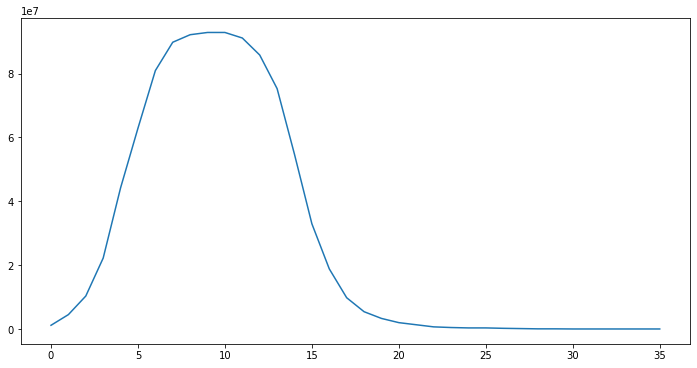

In [170]:
plt.figure(figsize=(12,6))
plt.plot(spectrum)

In [110]:
spectrum

array([1.17904300e+06, 4.58640317e+06, 1.05169936e+07, 2.26295813e+07,
       4.50458104e+07, 6.40999296e+07, 8.24822971e+07, 9.15293430e+07,
       9.39309276e+07, 9.46479462e+07, 9.46471574e+07, 9.28774086e+07,
       8.74471394e+07, 7.67179596e+07, 5.57292142e+07, 3.35649566e+07,
       1.91810961e+07, 9.97031051e+06, 5.51176127e+06, 3.36606695e+06,
       2.01987476e+06, 1.34655348e+06, 6.73422798e+05, 4.63045535e+05,
       3.36757694e+05, 3.36708913e+05, 2.10436878e+05, 1.26243159e+05,
       4.20927691e+04, 4.20928153e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

## Four panel, comparing different angles of CDM to SIDM

In [26]:
# function to make figure 
def fourPanelH1_likeAngles(hID):
    # some plotting params 
    intervals = [10, 20, 50]
    cdmC = 'coral'
    sidmC = 'royalblue'
    cdmWs = ['orangered', 'orangered', 'orangered']
    sidmWs = ['cornflowerblue', 'cornflowerblue', 'cornflowerblue']
    lw=3
    lwW = 1.5
    ms = 35
    
    # get data paths for specified halo 
    cdmPath, sidmPath = getfilepath(hID)
    
    cdmFiles = glob.glob(cdmPath+'/*.fits')
    cdmFiles.sort()
    if len(cdmFiles) == 4: cdmFiles = cdmFiles[1:]
    sidmFiles = glob.glob(sidmPath+'/*.fits')
    sidmFiles.sort()
    
    fig, axs = plt.subplots(3,1, figsize=(10, 14))
    
    # iterate over orientations 
    for i in range(len(sidmFiles)):
        # load data for each file
        cdmf = fits.open(cdmFiles[i])[0]
        cdmInitSpd = cdmf.header['CRVAL3']
        cdmDeltaSpd = cdmf.header['CDELT3']
        cdmDat = cdmf.data
        
        sidmf = fits.open(sidmFiles[i])[0]
        sidmInitSpd = sidmf.header['CRVAL3']
        sidmDeltaSpd = sidmf.header['CDELT3']
        sidmDat = sidmf.data
        
        # integrate
        cdmX, cdmY = integrateSpectral(cdmDat, cdmInitSpd, cdmDeltaSpd)
        sidmX, sidmY = integrateSpectral(sidmDat, sidmInitSpd, sidmDeltaSpd)
        
        # plot curves 
        lcdm, = axs[i].plot(cdmX, cdmY, linewidth=lw, c=cdmC)
        lsidm, = axs[i].plot(sidmX, sidmY, linewidth=lw, c=sidmC)
        
        # do line widths of cmd 
        vmax = max(cdmY)
        for j,p in enumerate(intervals):
            val = (p/100)*vmax

            idxs_mass = np.argwhere(np.diff(np.sign(cdmY - np.full(len(cdmY),val)))).flatten()
            if len(idxs_mass) < 2: continue 
            x1 = (cdmX[idxs_mass[0]]+cdmX[idxs_mass[0]+1])/2
            x2 = (cdmX[idxs_mass[1]]+cdmX[idxs_mass[1]+1])/2
            
            axs[i].plot([x1,x2],[val,val], linewidth=lwW, color=cdmWs[j], zorder=2)
            axs[i].scatter([x1,x2],[val,val], color=cdmWs[j], s=25, label='_nolegend_', zorder=2)
        
        # do line widths of sidm 
        vmax = max(sidmY)
        for j,p in enumerate(intervals):
            val = (p/100)*vmax

            idxs_mass = np.argwhere(np.diff(np.sign(sidmY - np.full(len(sidmY),val)))).flatten()
            if len(idxs_mass) < 2: continue 
            x1 = (sidmX[idxs_mass[0]]+sidmX[idxs_mass[0]+1])/2
            x2 = (sidmX[idxs_mass[1]]+sidmX[idxs_mass[1]+1])/2
            
            axs[i].plot([x1,x2],[val,val], linewidth=lwW, color=sidmWs[j], zorder=2)
            axs[i].scatter([x1,x2],[val,val], color=sidmWs[j], s=25, label='_nolegend_', zorder=2, marker='^')
        
        # prettify 
        titles = [r'$\hat{x}$ Orientation', r'$\hat{y}$ Orientation', r'$\hat{z}$ Orientation']
        axs[i].set_title(titles[i], fontsize=20)
        
        axs[i].set_xlabel('Velocity [km/s]', fontsize=14)
        axs[i].set_ylabel(r'$M_\odot$', fontsize=18)
        
        axs[i].legend([lcdm, lsidm],['CDM','SIDM'])

    plt.tight_layout()

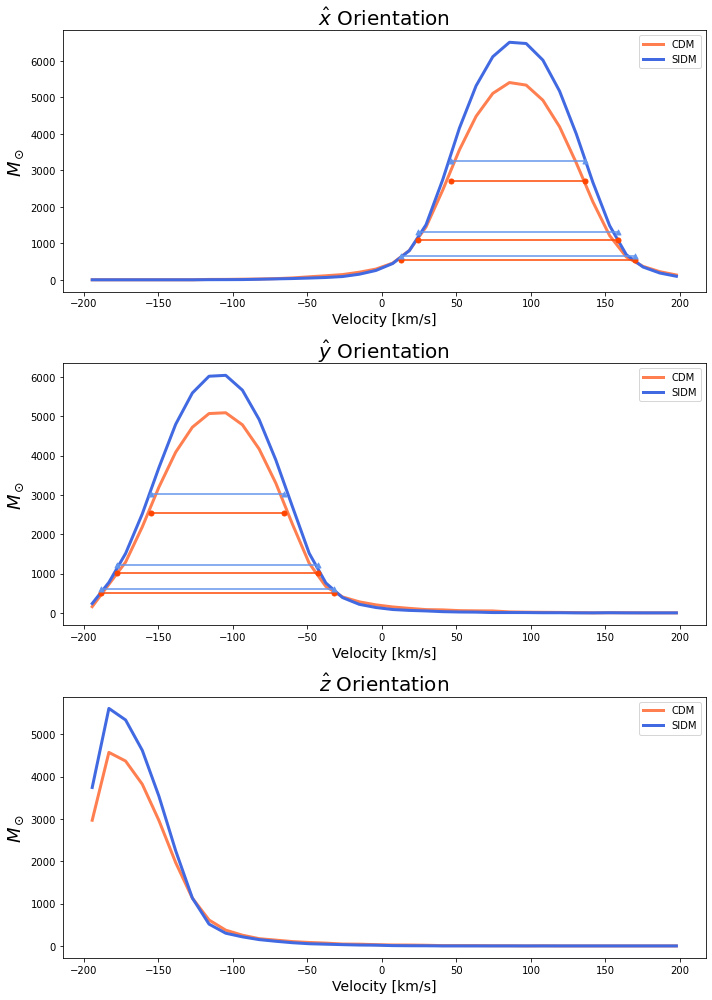

In [28]:
hidx = 1
fourPanelH1_likeAngles(haloIDs[hidx])
plt.savefig('figures/r'+str(haloIDs[hidx])+'_H1velocity.png')

In [30]:
getfilepath(468)

['/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r468.romulus25.3072g1HsbBH/r468.romulus25.3072g1HsbBH.004096',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r468.romulus25cvdXsec.3072g1HsbBH/r468.romulus25cvdXsec.3072g1HsbBH.004096']

## V_max and HI width

Goal here is to check the correlation between Vmax (halo) and the Hi width, in both CDM and SIDM

In [2]:
cdmgals,sidmgals = util.getGalaxies()

In [58]:
# first cdm
cdmVmaxs = []
for g in cdmgals:
    f = util.getfilepath(g)[0]

    cdmFile = f + '/r'+str(g)+'.romulus25.3072g1HsbBH.004096'
    
    sCDM = pynbody.load(cdmFile)
    sCDM.physical_units()
    hCDM = sCDM.halos()[1]
    
    # center based on potential
    cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
    sCDM['pos'] -= cen_pot
    
    # profile range
    pmin = '0.01 kpc'
    #pmax = pynbody.analysis.halo.virial_radius(h1) / 4
    pmax = '50 kpc'
    
    # rotation curve
    pCDM = pynbody.analysis.profile.Profile(hCDM.d, rmin=pmin, rmax=pmax, type='lin')
    
    # thrice for later plot; we have 3 orientations per gal 
    for _ in [0,0,0]:
        cdmVmaxs.append(float(pCDM['v_circ'].max()))
    
# now sidm
sidmVmaxs = []
for g in sidmgals:
    f = util.getfilepath(g)[1]
    
    sidmFile = f+'/r'+str(g)+'.romulus25cvdXsec.3072g1HsbBH.004096'
    
    sSIDM = pynbody.load(sidmFile)
    sSIDM.physical_units()
    hSIDM = sSIDM.halos()[1]
    
    # center based on potential 
    cen_pot = pynbody.analysis.halo.center(hSIDM, mode='pot', retcen=True)
    sSIDM['pos'] -= cen_pot
    
    # profile range 
    pmin = '0.01 kpc'
    pmax = '50.0 kpc'
    
    # rot 
    pSIDM = pynbody.analysis.profile.Profile(hSIDM.d, rmin=pmin, rmax=pmax, type='lin')
    
    # thrice for later; we have 3 orientations per gal
    for _ in [0,0,0]:
        sidmVmaxs.append(float(pSIDM['v_circ'].max()))
        
cdmVmaxs = np.array(cdmVmaxs)
sidmVmaxs = np.array(sidmVmaxs)

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


In [59]:
# now get h1 vel width data
dfh1 = pd.read_csv('~/H1-merian/h1lines/widths.txt', sep='\t')

# clean out -1's 
w50cdm = dfh1['w50_cdm'].to_numpy()
w20cdm = dfh1['w20_cdm'].to_numpy()
w10cdm = dfh1['w10_cdm'].to_numpy()

In [60]:
w50cdm

array([145.599993  , 134.3999978 , 145.5999935 ,  67.19999835,
        78.3999985 ,  78.4000035 , 156.7999972 ,  78.399999  ,
        55.999995  ,  89.59999835,  67.199998  ,  89.5999985 ,
        89.599998  ,  78.3999985 ,  78.400003  ,  -1.        ,
        67.199998  ,  89.599992  ])

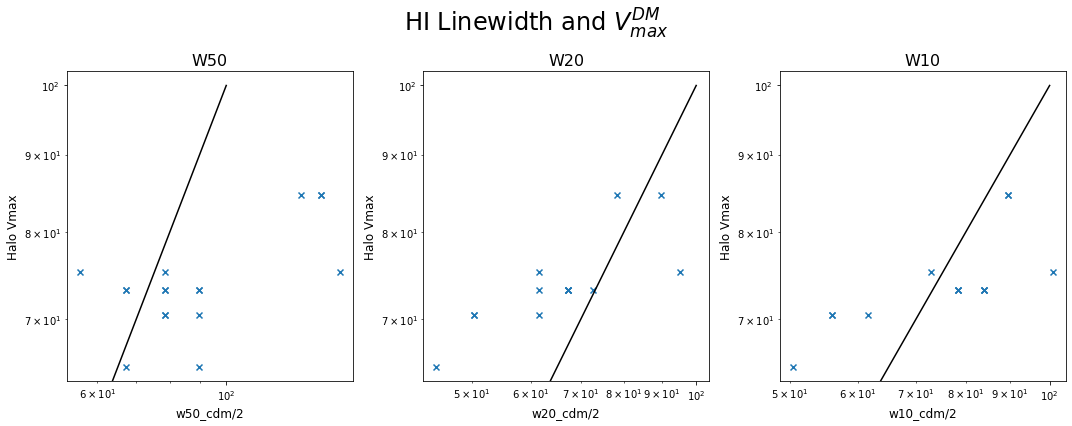

In [61]:
fig, axs = plt.subplots(1,3, figsize=(15,6))

axs[0].scatter(w50cdm[np.where(w50cdm > -1.0)[0]], cdmVmaxs[np.where(w50cdm > -1.0)[0]], marker='x')
axs[1].scatter(dfh1['w20_cdm']/2, cdmVmaxs, marker='x')
axs[2].scatter(dfh1['w10_cdm']/2, cdmVmaxs, marker='x')

for ax in axs:
    ax.plot([0,100], [0,100], 'k')
    #ax.set_xlim(40)
    #ax.set_ylim([20,60])
    ax.set_ylabel('Halo Vmax', fontsize=12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
axs[0].set_xlabel('w50_cdm/2', fontsize=12)
axs[1].set_xlabel('w20_cdm/2', fontsize=12)
axs[2].set_xlabel('w10_cdm/2', fontsize=12)    
    
axs[0].set_title('W50', fontsize=16)
axs[1].set_title('W20', fontsize=16)
axs[2].set_title('W10', fontsize=16)

plt.suptitle(r'HI Linewidth and $V_{max}^{DM}$', fontsize=24)

fig.tight_layout()

In [3]:
g = cdmgals[0]
f = util.getfilepath(g)[0]

cdmFile = f + '/r'+str(g)+'.romulus25.3072g1HsbBH.004096'
    
sCDM = pynbody.load(cdmFile)
sCDM.physical_units()
hCDM = sCDM.halos()[1]

In [13]:
me = pynbody.analysis.profile.Profile(hCDM)

In [15]:
me['mass_enc']

SimArray([2.10074318e+06, 7.51479643e+06, 1.64208671e+07, 2.96898038e+07,
          4.78951614e+07, 7.08111518e+07, 1.00994909e+08, 1.38834868e+08,
          1.84236690e+08, 2.37357972e+08, 3.00924828e+08, 3.72606096e+08,
          4.52810265e+08, 5.45927243e+08, 6.52396019e+08, 7.68817123e+08,
          8.96797259e+08, 1.04231374e+09, 1.21058633e+09, 1.40029956e+09,
          1.61162992e+09, 1.84708744e+09, 2.11348785e+09, 2.41304012e+09,
          2.74184265e+09, 3.09968059e+09, 3.48833490e+09, 3.91991588e+09,
          4.38271444e+09, 4.88580613e+09, 5.42787340e+09, 6.01453585e+09,
          6.64797067e+09, 7.32544695e+09, 8.06686498e+09, 8.87219910e+09,
          9.76130448e+09, 1.07619939e+10, 1.18801715e+10, 1.31342846e+10,
          1.45642920e+10, 1.61766004e+10, 1.80144296e+10, 2.01168216e+10,
          2.25487427e+10, 2.54534125e+10, 2.92025356e+10, 3.41893221e+10,
          4.08217610e+10, 4.96542123e+10, 5.73118847e+10, 6.31871863e+10,
          6.77782158e+10, 7.15665921e+